In [2]:
%pip install tabulate

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import plotly.express as px
import plotly.subplots
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from tabulate import tabulate
from scipy.stats import fisher_exact
import itertools


In [35]:
# create dummy variables for motivational outcomes (Y) and independent variables (x)
df = pd.read_csv("ungrouped_ALL_with_regions.txt")

# first we select 2 types of outcome variable - on 1-5 and 1-7 scales
# we create dictionary to recode the values in each category of outcome variables

columns5 = ['Satisfied',
            'Stay',
            'Values',
            'Meaning',
            'Ideas',
            ]

columns7 = ['Strong',
           'Drained',
           'Frustrated']

# we create dictionary to recode the values in each category of outcome variables
# neutral (3) is considered positive, i.e. Y=1 if neutral)
mapping5 = {
    5: 1,
    4: 1,
    3: 1,
    2: 0,
    1: 0
}

# NB: this is the current coding for frequencies:
#    "Every day": 7,
#    "Very often": 6,
#    "Often": 5,
#    "Sometimes": 4,
#    "Rarely": 3,
#    "Almost never": 2,
#    "Never": 1
# We set the cut off point between 4 (sometimes) and 5 (often), i.e. Y=1 if "often"
mapping7 = {
    7: 1,
    6: 1,
    5: 1,
    4: 0,
    3: 0,
    2: 0,
    1: 0
}

df[columns5] = df[columns5].replace(mapping5)
df[columns7] = df[columns7].replace(mapping7)

df.head(20)

#Independent Variables to convert into dummy variables for Odds Ratio computations
# we create dictionary to recode the values in each category of outcome variables
# cutoff point: 3.5 and above considered positive.
# We keep the original continous variables in the data.

df['Well'] = df['Well-being']
df['3Needsmet'] = df['Needs']
df['Autonomous'] = df['Autonomy']
df['Belongs'] = df['Belonging']
df['Competent'] = df['Competence']
df['LeaderOK'] = df['Leadership']
df['Understood'] = df['Understands']
df['Encouraged'] = df['Encourages']
df['Heard'] = df['Listens']
df['ManagementOK'] = df['Management']
df['ReturnsOK'] = df['Returns']
df['RewardsOK'] = df['Rewards']
df['StatusOK'] = df['Status']
   
DummyColumns = [
    'Well',
    '3Needsmet',
    'Autonomous',
    'Belongs',
    'Competent',
    'LeaderOK',
    'Understood',
    'Encouraged',
    'Heard',
    'ManagementOK',
    'ReturnsOK',
    'RewardsOK',
    'StatusOK'
    ] 

# Calculate the rounded value row by row and assign it to a new dummy variable column
# By rounding we can have 3.5 and above as 1  and below 3.5 as 0
df[DummyColumns] = df[DummyColumns].round(0)
df[DummyColumns] = df[DummyColumns].astype(int)
df
mappingX = {
    5: 1,
    4: 1,
    3: 0,
    2: 0,
    1: 0
}

df[DummyColumns] = df[DummyColumns].replace(mappingX)

#for Var_x in df[DummyColumn]:
#    Var_x = float(Var_x)
#    if Var_x < 4 :
#        Var_x = 0
#    else: Var_x = 1
    
#Variables to keep for logistic regressions
columns = ['Strong', 'Drained', 'Frustrated',
           'Satisfied', 'Stay', 'Values', 'Meaning', 'Ideas',
           'Country', 'Staff', 'Volunteer',
           'Well-being', 'Needs', 'Autonomy', 'Belonging', 'Competence',
           'Leadership', 'Understands', 'Encourages', 'Listens',
           'Management', 'Returns', 'Rewards', 'Status',
           'Well', '3Needsmet', 'Autonomous', 'Belongs', 'Competent',
           'LeaderOK', 'Understood', 'Encouraged', 'Heard',
           'ManagementOK', 'ReturnsOK', 'RewardsOK', 'StatusOK'
          ]

LogReg_df=df[columns]


LogReg_df.to_csv('LogReg_df.csv', index=False)
df.head(7)

#df.shape

,Team Name,Well-being,Needs,Engagement,Autonomy,Belonging,Competence,Leadership,Management,Returns,...,Autonomous,Belongs,LeaderOK,Understood,Encouraged,Heard,ManagementOK,ReturnsOK,RewardsOK,StatusOK
0,Gambian RC,3.2,4.9,4.4,5.0,5.0,4.5,4.0,4.5,5.0,...,1,1,1,0,1,1,1,1,1,1
1,Gambian RC,3.7,4.5,4.8,4.7,4.3,4.5,4.7,4.3,5.0,...,1,1,1,1,1,1,1,1,0,1
2,Gambian RC,3.9,3.9,3.4,4.0,4.0,3.5,1.0,3.5,3.0,...,1,1,0,0,0,0,1,0,1,1
3,Gambian RC,3.7,3.6,4.2,3.7,4.0,3.0,4.0,4.3,5.0,...,1,1,1,1,1,1,1,1,1,1
4,Gambian RC,4.6,4.8,4.4,4.7,4.7,5.0,4.0,4.0,5.0,...,1,1,1,1,1,1,1,1,0,1
5,Gambian RC,3.7,3.8,4.2,3.3,4.3,3.5,3.3,4.0,4.5,...,0,1,0,1,0,0,1,1,0,1
6,Gambian RC,4.6,4.4,4.8,4.7,4.7,3.5,4.3,4.5,5.0,...,1,1,1,1,1,1,1,1,1,1


In [5]:
#  Model 1: Y= Stay X='Leadership', 'Management', 'Staff'

df = pd.read_csv('LogReg_df.csv')
                 
columns = ['Stay',
           'Leadership', 'Management', 'Staff']

df=df[columns]

df.groupby('Stay').mean(columns)

,Leadership,Management,Staff
Stay,,,
0,3.196673,3.402544,0.138943
1,4.158612,4.175620,0.139793


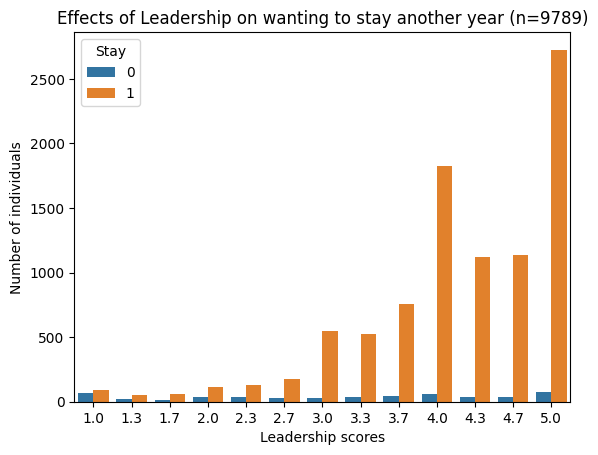

In [6]:
#  Model 1: Y= Stay X='Leadership', 'Management', 'Staff'

df = pd.read_csv('LogReg_df.csv')

# Count the total number of respondents (n)
n = df['Volunteer'].sum() + df['Staff'].sum()

columns = ['Stay',
           'Leadership', 'Management', 'Staff']

df=df[columns]

df.groupby('Stay').mean(columns)

sns.countplot(data=df, x='Leadership', hue='Stay')
plt.title(f'Effects of Leadership on wanting to stay another year (n={n})')
plt.xlabel('Leadership scores')
plt.ylabel('Number of individuals')
plt.savefig('LogReg_Stay-Lead')

In [7]:
#  Model 1.1 : Y= Stay X='Wellbeing', 'Staff'

df = pd.read_csv('LogReg_df.csv')

columns = ['Stay',
           'Well-being', 'Staff']

df=df[columns]

df.groupby('Stay').mean(columns)


,Well-being,Staff
Stay,,
0,3.479648,0.138943
1,3.951347,0.139793


In [8]:
#  Risk and Odds ratios
#  first method using contingency table, variable by variable

df = pd.read_csv('LogReg_df.csv')

columns = ['Stay',
           'Staff']

df_count=df[columns].sum()
#print(df_count)


df['Staff_Stay'] = 0
df['Staff_Leave'] = 0
df['Volunteer_Stay'] = 0
df['Volunteer_Leave'] = 0

columns = ['Stay',
           'Staff',
            'Staff_Stay',
            'Staff_Leave',
            'Volunteer_Stay',
            'Volunteer_Leave']

# convert variables to integer (for some reason they are strings)
df[columns] = df[columns].astype(int)
           
df['Staff_Stay'] = 1 * ((df['Staff'] == 1) & (df['Stay'] == 1))
df['Staff_Leave'] = 1 * ((df['Staff'] == 1) & (df['Stay'] == 0))
df['Volunteer_Stay'] = 1 * ((df['Staff'] == 0) & (df['Stay'] == 1))
df['Volunteer_Leave'] = 1 * ((df['Staff'] == 0) & (df['Stay'] == 0))
        
#df.tail()

# sums for 2 by 2 contingency table a, b, c, d
# How much more likely are staff will leave than volunteers?

a = df['Staff_Leave'].sum()
b = df['Staff_Stay'].sum()
c = df['Volunteer_Leave'].sum()
d = df['Volunteer_Stay'].sum()

# computing the relative risks of leaving for staff and volunteers and the odds ratio: 
RR_Staff = a/b
RR_Volunteers = c/d
OR = (a/b)/(c/d)
print(a, b, round(RR_Staff,2), c, d, round(RR_Volunteers,2), round(OR,1))


71 1297 0.05 440 7981 0.06 1.0


In [ ]:
#  Odds ratios,
# 2nd method using logistic regression, variable by variable
from scipy.stats import fisher_exact
import itertools
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('LogReg_df.csv')

columns = ['Stay',
           'Staff']
df=df[columns]
clf = LogisticRegression()
clf.fit(df[['Stay']],df[['Staff']].values)
odds_ratio=np.exp(clf.coef_)

print('Odds for staff staying, compared to volunteers:', odds_ratio)

Odds for staff staying, compared to voluneers: [[1.00574601]]


c:\Users\gabriel.pictet\AppData\Local\anaconda3\envs\MotiSurveyData\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#  Odds ratios for all outcome variables:
#  staying, being satisfied, sharing ideas, values, meaning,
#  being frustrated being drained
#  and selected independent variables: Needs, Management, leadership, etc.
#  using logistic regression
#  use this to prepare odds ratio pivot table for VOL and STAFF

from scipy.stats import fisher_exact
import itertools
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('LogReg_df.csv')

columnY = ['Stay', 'Drained', 'Frustrated', 'Satisfied', 'Ideas', 'Values', 'Meaning'] 
columnX = ['Staff', '3Needsmet', 'Autonomous', 'Belongs', 'Competent',
           'LeaderOK', 'Understood', 'Encouraged', 'Heard',
           'ManagementOK', 'ReturnsOK', 'RewardsOK', 'StatusOK']

#create the dataframe that will store the outputs
results_df= pd.DataFrame(columns=['Outcome', 'Factor', 'Odds ratio'])


for Y in columnY:
    for X in columnX:
        clf = LogisticRegression(penalty=None)
        # Reshape the data to be 2D
        X_data = df[X].values.reshape(-1, 1)
        Y_data = df[Y]
        clf.fit(X_data, Y_data)
        odds_ratio = np.exp(clf.coef_)
        print(Y, X, odds_ratio)
 
        # Append results to the results_df DataFrame using pd.concat
        new_row = pd.DataFrame({'Outcome': [Y], 'Factor': [X], 'Odds ratio': [odds_ratio[0][0]]})
        results_df = pd.concat([results_df, new_row], ignore_index=True)
# Display the results DataFrame
print(results_df)

# Save the results DataFrame to a CSV file
results_df.to_csv('odds_ratios_ALL.csv', index=False)

# Pivot the results_df DataFrame
pivot_table = results_df.pivot(index='Factor', columns='Outcome', values='Odds ratio')

# Display the pivot_table
print(pivot_table)

# Save the Pivot table DataFrame to a CSV file
pivot_table.to_excel('odds_ratios_PivotTable_ALL.xlsx', index=False)      

Stay Staff [[1.00239006]]
Stay 3Needsmet [[8.36761496]]
Stay Autonomous [[6.68002426]]
Stay Belongs [[4.67203074]]
Stay Competent [[5.7775812]]
Stay LeaderOK [[4.71551313]]
Stay Understood [[4.62682534]]
Stay Encouraged [[3.51886499]]
Stay Heard [[4.37688713]]
Stay ManagementOK [[7.57746598]]
Stay ReturnsOK [[6.52008444]]
Stay RewardsOK [[4.249502]]
Stay StatusOK [[6.95528362]]
Drained Staff [[1.68929227]]
Drained 3Needsmet [[0.3784879]]
Drained Autonomous [[0.3788752]]
Drained Belongs [[0.59822809]]
Drained Competent [[0.60144123]]
Drained LeaderOK [[0.60297971]]
Drained Understood [[0.54282134]]
Drained Encouraged [[0.72659073]]
Drained Heard [[0.70875759]]
Drained ManagementOK [[0.48073614]]
Drained ReturnsOK [[0.69373809]]
Drained RewardsOK [[0.61976538]]
Drained StatusOK [[0.5655377]]
Frustrated Staff [[1.97768661]]
Frustrated 3Needsmet [[0.20183093]]


C:\Users\gabriel.pictet\AppData\Local\Temp\ipykernel_20640\990369810.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


Frustrated Autonomous [[0.2302963]]
Frustrated Belongs [[0.33614633]]
Frustrated Competent [[0.35797644]]
Frustrated LeaderOK [[0.34915701]]
Frustrated Understood [[0.35420141]]
Frustrated Encouraged [[0.42098273]]
Frustrated Heard [[0.39228337]]
Frustrated ManagementOK [[0.23899363]]
Frustrated ReturnsOK [[0.32019963]]
Frustrated RewardsOK [[0.40155285]]
Frustrated StatusOK [[0.31750322]]
Satisfied Staff [[0.66845521]]
Satisfied 3Needsmet [[27.72992467]]
Satisfied Autonomous [[23.13421311]]
Satisfied Belongs [[13.81440531]]
Satisfied Competent [[11.36912469]]
Satisfied LeaderOK [[13.00207985]]
Satisfied Understood [[12.16912848]]
Satisfied Encouraged [[8.47988007]]
Satisfied Heard [[9.49428712]]
Satisfied ManagementOK [[24.51588995]]
Satisfied ReturnsOK [[15.23633467]]
Satisfied RewardsOK [[15.79431333]]
Satisfied StatusOK [[12.61506574]]
Ideas Staff [[2.19233213]]
Ideas 3Needsmet [[10.1752535]]
Ideas Autonomous [[6.63587817]]
Ideas Belongs [[12.63647839]]
Ideas Competent [[6.41118985

In [33]:
#  Odds ratios for staying, being satisfied, being frustrated  and being drained
#  and selected independent variables: Needs, Management, leadership
#  using logistic regression
#  use this to prepare odds ratio pivot table for VOL and STAFF

from scipy.stats import fisher_exact
import itertools
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('LogReg_df.csv')

columnY = ['Stay', 'Drained', 'Frustrated', 'Satisfied'] 
columnX = ['Staff', '3Needsmet', 'Autonomous', 'Belongs', 'Competent',
           'LeaderOK', 'Understood', 'Encouraged', 'Heard',
           'ManagementOK', 'ReturnsOK', 'RewardsOK', 'StatusOK']

#create the dataframe that will store the outputs
results_df= pd.DataFrame(columns=['Outcome', 'Factor', 'Odds ratio'])


for Y in columnY:
    for X in columnX:
        clf = LogisticRegression(penalty=None)
        # Reshape the data to be 2D
        X_data = df[X].values.reshape(-1, 1)
        Y_data = df[Y]
        clf.fit(X_data, Y_data)
        odds_ratio = np.exp(clf.coef_)
        print(Y, X, odds_ratio)
        # Append results to the results_df DataFrame using pd.concat
        new_row = pd.DataFrame({'Outcome': [Y], 'Factor': [X], 'Odds ratio': [odds_ratio[0][0]]})
        results_df = pd.concat([results_df, new_row], ignore_index=True)

# Display the results DataFrame
print(results_df)

# Save the results DataFrame to a CSV file
results_df.to_csv('odds_ratios_ALL.csv', index=False)

# Pivot the results_df DataFrame
pivot_table = results_df.pivot(index='Factor', columns='Outcome', values='Odds ratio')

# Display the pivot_table
print(pivot_table)

# Save the Pivot table DataFrame to a CSV file
pivot_table.to_excel('odds_ratios_PivotTable_ALL.xlsx', index=False)      

Stay Staff [[1.00239006]]
Stay 3Needsmet [[8.36761496]]
Stay Autonomous [[6.68002426]]
Stay Belongs [[4.67203074]]
Stay Competent [[5.7775812]]
Stay LeaderOK [[4.71551313]]
Stay Understood [[4.62682534]]
Stay Encouraged [[3.51886499]]
Stay Heard [[4.37688713]]
Stay ManagementOK [[7.57746598]]
Stay ReturnsOK [[6.52008444]]
Stay RewardsOK [[4.249502]]
Stay StatusOK [[6.95528362]]
Drained Staff [[1.68929227]]
Drained 3Needsmet [[0.3784879]]
Drained Autonomous [[0.3788752]]
Drained Belongs [[0.59822809]]
Drained Competent [[0.60144123]]


C:\Users\gabriel.pictet\AppData\Local\Temp\ipykernel_20640\549965313.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


Drained LeaderOK [[0.60297971]]
Drained Understood [[0.54282134]]
Drained Encouraged [[0.72659073]]
Drained Heard [[0.70875759]]
Drained ManagementOK [[0.48073614]]
Drained ReturnsOK [[0.69373809]]
Drained RewardsOK [[0.61976538]]
Drained StatusOK [[0.5655377]]
Frustrated Staff [[1.97768661]]
Frustrated 3Needsmet [[0.20183093]]
Frustrated Autonomous [[0.2302963]]
Frustrated Belongs [[0.33614633]]
Frustrated Competent [[0.35797644]]
Frustrated LeaderOK [[0.34915701]]
Frustrated Understood [[0.35420141]]
Frustrated Encouraged [[0.42098273]]
Frustrated Heard [[0.39228337]]
Frustrated ManagementOK [[0.23899363]]
Frustrated ReturnsOK [[0.32019963]]
Frustrated RewardsOK [[0.40155285]]
Frustrated StatusOK [[0.31750322]]
Satisfied Staff [[0.66845521]]
Satisfied 3Needsmet [[27.72992467]]
Satisfied Autonomous [[23.13421311]]
Satisfied Belongs [[13.81440531]]
Satisfied Competent [[11.36912469]]
Satisfied LeaderOK [[13.00207985]]
Satisfied Understood [[12.16912848]]
Satisfied Encouraged [[8.479880

In [15]:
df = pd.read_csv('odds_ratios_ALL.csv')


# Pivot the results_df DataFrame
pivot_table = df.pivot(index='Factor', columns='Outcome', values='Odds ratio')

# Display the pivot_table
print(pivot_table)

# Save the Pivot table DataFrame to a CSV file
pivot_table.to_excel('odds_ratios_PivotTable_ALL.xlsx', index=False)

Outcome        Drained  Frustrated  Satisfied      Stay
Factor                                                 
3Needsmet     0.450758    0.254466  23.033793  6.375202
Autonomous    0.443746    0.270013  19.131648  5.334172
Belongs       0.654228    0.395703  12.632281  3.846910
Competent     0.654681    0.426551  10.053375  4.752736
Encouraged    0.850936    0.475218   7.919182  3.145586
Heard         0.807673    0.461458   8.919765  3.591247
LeaderOK      0.743126    0.432552  11.346704  3.875270
ManagementOK  0.555372    0.288757  22.210900  6.138108
ReturnsOK     0.734072    0.374836  13.560715  5.776357
RewardsOK     0.761259    0.499300  14.831092  3.403189
Staff         1.819236    2.674970   0.429659  0.659360
StatusOK      0.719933    0.397537  10.852709  5.592361
Understood    0.655918    0.461698  10.285301  3.727680


In [32]:
#  Odds ratios STAFF ONLY
#  for staying, being satisfied, being frustrated and being drained
#  and selected independent variables: Needs, Management, leadership
#  using logistic regression
#  use this to prepare odds ratio pivot table for VOL and STAFF


# Load the data
df = pd.read_csv('LogReg_df.csv')

# Keep only volunteers
df = df[df['Staff'] == 0]

columnY = ['Stay', 'Drained', 'Frustrated', 'Satisfied'] 
columnX = ['3Needsmet', 'Autonomous', 'Belongs', 'Competent',
           'LeaderOK', 'Understood', 'Encouraged', 'Heard',
           'ManagementOK', 'ReturnsOK', 'RewardsOK', 'StatusOK']

#create the dataframe that will store the outputs
results_df= pd.DataFrame(columns=['Outcome', 'Factor', 'Odds ratio'])


for Y in columnY:
    for X in columnX:
        clf = LogisticRegression(penalty=None)
        # Reshape the data to be 2D
        X_data = df[X].values.reshape(-1, 1)
        Y_data = df[Y]
        clf.fit(X_data, Y_data)
        odds_ratio = np.exp(clf.coef_)
        print(Y, X, odds_ratio)
        # Append results to the results_df DataFrame
        #results_df = results_df.append({'Outcome': Y, 'Factor': X, 'Odds ratio': odds_ratio[0][0]}, ignore_index=True)
        # Append results to the results_df DataFrame using pd.concat
        new_row = pd.DataFrame({'Outcome': [Y], 'Factor': [X], 'Odds ratio': [odds_ratio[0][0]]})
        results_df = pd.concat([results_df, new_row], ignore_index=True)

# Display the results DataFrame
print(results_df)

# Save the results DataFrame to a CSV file
results_df.to_csv('odds_ratios_VOL.csv', index=False)

df = pd.read_csv('odds_ratios_VOL.csv')

# Display the pivot_table
print(pivot_table)

# Save the Pivot table DataFrame to a CSV file
pivot_table.to_excel('odds_ratios_PivotTable_VOL.xlsx', index=False)

# Pivot the results_df DataFrame
pivot_table = df.pivot(index='Factor', columns='Outcome', values='Odds ratio')

# Display the pivot_table
print(pivot_table)

# Save the Pivot table DataFrame to a CSV file
pivot_table.to_excel('odds_ratios_PivotTable_VOL.xlsx', index=False)

Stay 3Needsmet [[7.74744541]]
Stay Autonomous [[6.41318602]]
Stay Belongs [[4.26327846]]
Stay Competent [[5.83640518]]
Stay LeaderOK [[4.38057734]]
Stay Understood [[4.26357763]]
Stay Encouraged [[3.26570387]]
Stay Heard [[4.1981895]]
Stay ManagementOK [[7.05229405]]
Stay ReturnsOK [[6.50676879]]
Stay RewardsOK [[3.8029852]]
Stay StatusOK [[7.00809416]]
Drained 3Needsmet [[0.43087112]]
Drained Autonomous [[0.43359438]]
Drained Belongs [[0.66758252]]
Drained Competent [[0.70011577]]
Drained LeaderOK [[0.69082671]]
Drained Understood [[0.60561025]]
Drained Encouraged [[0.82414988]]
Drained Heard [[0.78704645]]
Drained ManagementOK [[0.58958428]]
Drained ReturnsOK [[0.82862253]]
Drained RewardsOK [[0.71137761]]
Drained StatusOK [[0.73239684]]
Frustrated 3Needsmet [[0.22008759]]
Frustrated Autonomous [[0.24721098]]
Frustrated Belongs [[0.36724043]]


C:\Users\gabriel.pictet\AppData\Local\Temp\ipykernel_20640\181630536.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


Frustrated Competent [[0.41467198]]
Frustrated LeaderOK [[0.37697474]]
Frustrated Understood [[0.38060537]]
Frustrated Encouraged [[0.45277563]]
Frustrated Heard [[0.42308795]]
Frustrated ManagementOK [[0.29441573]]
Frustrated ReturnsOK [[0.37526437]]
Frustrated RewardsOK [[0.47783534]]
Frustrated StatusOK [[0.38814638]]
Satisfied 3Needsmet [[29.33132592]]
Satisfied Autonomous [[25.026636]]
Satisfied Belongs [[15.92632444]]
Satisfied Competent [[12.02146899]]
Satisfied LeaderOK [[15.59035569]]
Satisfied Understood [[14.21161563]]
Satisfied Encouraged [[9.2740739]]
Satisfied Heard [[11.35457951]]
Satisfied ManagementOK [[24.55249163]]
Satisfied ReturnsOK [[16.28529401]]
Satisfied RewardsOK [[15.96213067]]
Satisfied StatusOK [[14.43918507]]
       Outcome        Factor  Odds ratio
0         Stay     3Needsmet    7.747445
1         Stay    Autonomous    6.413186
2         Stay       Belongs    4.263278
3         Stay     Competent    5.836405
4         Stay      LeaderOK    4.380577
5    

In [31]:
#  Odds ratios STAFF ONLY
#  for staying, being satisfied, being frustrated and being drained
#  and selected independent variables: Needs, Management, leadership
#  using logistic regression
#  use this to prepare odds ratio pivot table for VOL and STAFF


# Load the data
df = pd.read_csv('LogReg_df.csv')
# Keep only staff
df = df[df['Staff'] == 1]

columnY = ['Stay', 'Drained', 'Frustrated', 'Satisfied'] 
columnX = ['3Needsmet', 'Autonomous', 'Belongs', 'Competent',
           'LeaderOK', 'Understood', 'Encouraged', 'Heard',
           'ManagementOK', 'ReturnsOK', 'RewardsOK', 'StatusOK']

#create the dataframe that will store the outputs
results_df= pd.DataFrame(columns=['Outcome', 'Factor', 'Odds ratio'])


for Y in columnY:
    for X in columnX:
        clf = LogisticRegression(penalty=None)
        # Reshape the data to be 2D
        X_data = df[X].values.reshape(-1, 1)
        Y_data = df[Y]
        clf.fit(X_data, Y_data)
        odds_ratio = np.exp(clf.coef_)
        print(Y, X, odds_ratio)
        # Append results to the results_df DataFrame using pd.concat
        new_row = pd.DataFrame({'Outcome': [Y], 'Factor': [X], 'Odds ratio': [odds_ratio[0][0]]})
        results_df = pd.concat([results_df, new_row], ignore_index=True)
# Display the results DataFrame
print(results_df)

# Save the results DataFrame to a CSV file
results_df.to_csv('odds_ratios_STAFF.csv', index=False)

df = pd.read_csv('odds_ratios_STAFF.csv')

# Pivot the results_df DataFrame
pivot_table = df.pivot(index='Factor', columns='Outcome', values='Odds ratio')

# Display the pivot_table
print(pivot_table)

# Save the Pivot table DataFrame to a CSV file
pivot_table.to_excel('odds_ratios_PivotTable_STAFF.xlsx', index=False)

# Pivot the results_df DataFrame
pivot_table = df.pivot(index='Factor', columns='Outcome', values='Odds ratio')

# Display the pivot_table
print(pivot_table)

# Save the Pivot table DataFrame to a CSV file
pivot_table.to_excel('odds_ratios_PivotTable_STAFF.xlsx', index=False)

Stay 3Needsmet [[13.46853435]]
Stay Autonomous [[8.73686884]]
Stay Belongs [[8.26894841]]
Stay Competent [[5.50809853]]
Stay LeaderOK [[7.63962892]]
Stay Understood [[7.7600512]]
Stay Encouraged [[5.72297927]]
Stay Heard [[5.67591458]]
Stay ManagementOK [[13.1529142]]
Stay ReturnsOK [[6.8326537]]
Stay RewardsOK [[12.27192306]]
Stay StatusOK [[6.95994882]]
Drained 3Needsmet [[0.2161407]]
Drained Autonomous [[0.22889355]]
Drained Belongs [[0.34981509]]
Drained Competent [[0.3549524]]
Drained LeaderOK [[0.36648796]]
Drained Understood [[0.33407915]]
Drained Encouraged [[0.46434368]]
Drained Heard [[0.46667353]]
Drained ManagementOK [[0.27550579]]
Drained ReturnsOK [[0.42296899]]
Drained RewardsOK [[0.40281999]]
Drained StatusOK [[0.27054839]]
Frustrated 3Needsmet [[0.14309655]]
Frustrated Autonomous [[0.19014402]]
Frustrated Belongs [[0.22477094]]
Frustrated Competent [[0.23054572]]
Frustrated LeaderOK [[0.27937657]]
Frustrated Understood [[0.26784004]]
Frustrated Encouraged [[0.34213081]

C:\Users\gabriel.pictet\AppData\Local\Temp\ipykernel_20640\1765403761.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


Frustrated ReturnsOK [[0.21387173]]
Frustrated RewardsOK [[0.24732797]]
Frustrated StatusOK [[0.19258791]]
Satisfied 3Needsmet [[21.5617063]]
Satisfied Autonomous [[15.92635337]]
Satisfied Belongs [[8.1813864]]
Satisfied Competent [[8.63090085]]
Satisfied LeaderOK [[6.20323004]]
Satisfied Understood [[6.73596332]]
Satisfied Encouraged [[5.63443739]]
Satisfied Heard [[4.69105405]]
Satisfied ManagementOK [[24.1398378]]
Satisfied ReturnsOK [[10.82738742]]
Satisfied RewardsOK [[14.45318048]]
Satisfied StatusOK [[6.64811549]]
       Outcome        Factor  Odds ratio
0         Stay     3Needsmet   13.468534
1         Stay    Autonomous    8.736869
2         Stay       Belongs    8.268948
3         Stay     Competent    5.508099
4         Stay      LeaderOK    7.639629
5         Stay    Understood    7.760051
6         Stay    Encouraged    5.722979
7         Stay         Heard    5.675915
8         Stay  ManagementOK   13.152914
9         Stay     ReturnsOK    6.832654
10        Stay     Rew

Stay Staff [[1.00239006]]
Drained Staff [[1.68929227]]
Frustrated Staff [[1.97768661]]
Satisfied Staff [[0.66845521]]
Ideas Staff [[2.19233213]]
Meaning Staff [[1.11295707]]
Values Staff [[0.8735266]]
3Needsmet Staff [[0.8699925]]
Autonomous Staff [[0.77796039]]


C:\Users\gabriel.pictet\AppData\Local\Temp\ipykernel_20640\1144631505.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


Belongs Staff [[1.04860914]]
Competent Staff [[0.81508065]]
LeaderOK Staff [[0.82692995]]
Understood Staff [[0.95124167]]
Encouraged Staff [[0.82974539]]
Heard Staff [[0.92028473]]
ManagementOK Staff [[0.61872193]]
ReturnsOK Staff [[0.72486423]]
RewardsOK Staff [[0.66707571]]
StatusOK Staff [[0.70190458]]
         Outcome Staff  Odds ratio Factor
0           Stay   NaN    1.002390  Staff
1        Drained   NaN    1.689292  Staff
2     Frustrated   NaN    1.977687  Staff
3      Satisfied   NaN    0.668455  Staff
4          Ideas   NaN    2.192332  Staff
5        Meaning   NaN    1.112957  Staff
6         Values   NaN    0.873527  Staff
7      3Needsmet   NaN    0.869992  Staff
8     Autonomous   NaN    0.777960  Staff
9        Belongs   NaN    1.048609  Staff
10     Competent   NaN    0.815081  Staff
11      LeaderOK   NaN    0.826930  Staff
12    Understood   NaN    0.951242  Staff
13    Encouraged   NaN    0.829745  Staff
14         Heard   NaN    0.920285  Staff
15  ManagementOK   Na

C:\Users\gabriel.pictet\AppData\Local\Temp\ipykernel_20640\1144631505.py:34: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


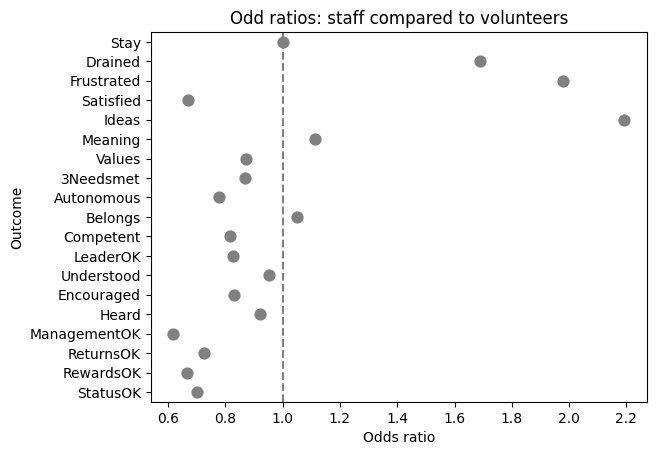

In [23]:
# Create forest plot to compare odds for staff compared to volunteers
df = pd.read_csv('LogReg_df.csv')

# Count the total number of respondents (n)
n = df['Volunteer'].sum() + df['Staff'].sum()

#prepare the data to compute the Odds Ratios
columnY = ['Stay', 'Drained', 'Frustrated', 'Satisfied', 'Ideas', 'Meaning', 'Values',
           '3Needsmet', 'Autonomous', 'Belongs', 'Competent',
           'LeaderOK', 'Understood', 'Encouraged', 'Heard',
           'ManagementOK', 'ReturnsOK', 'RewardsOK', 'StatusOK'] 
columnX = ['Staff']

#create the dataframe that will store the outputs
results_df= pd.DataFrame(columns=['Outcome', 'Staff', 'Odds ratio'])


for Y in columnY:
    for X in columnX:
        clf = LogisticRegression(penalty=None)
        # Reshape the data to be 2D
        X_data = df[X].values.reshape(-1, 1)
        Y_data = df[Y]
        clf.fit(X_data, Y_data)
        odds_ratio = np.exp(clf.coef_)
        print(Y, X, odds_ratio)
      # Append results to the results_df DataFrame using pd.concat
        new_row = pd.DataFrame({'Outcome': [Y], 'Factor': [X], 'Odds ratio': [odds_ratio[0][0]]})
        results_df = pd.concat([results_df, new_row], ignore_index=True)

# Display the results DataFrame
print(results_df)

sns.pointplot(
    data=results_df, x="Odds ratio", y="Outcome",
    errorbar=("pi", 100), capsize=.4, join=False, color=".5",
)

# Add the vertical line to the first subplot
plt.axvline(x=1, color='gray', linestyle='--')

plt.title('Odd ratios: staff compared to volunteers')

plt.savefig('ALL_OR_forestplot.png')

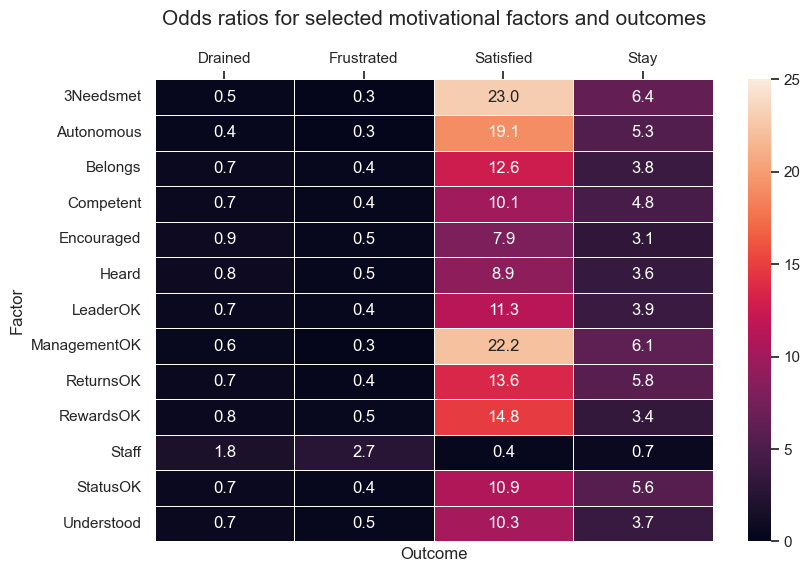

In [24]:
# heatmap to represent odds ratios for all data, staff and volunteers combined
sns.set_theme()

df = pd.read_csv('odds_ratios_ALL.csv')

# Pivot the results_df DataFrame
pivot_table = df.pivot(index='Factor', columns='Outcome', values='Odds ratio')

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(pivot_table, annot=True, fmt=".1f", vmin=0, vmax=25, linewidths=.5, ax=ax)
ax.xaxis.tick_top()
#ax.set_xlabel('Outcome', x=0.5)


plt.title('Odds ratios for selected motivational factors and outcomes', x=0.5, y=1.1, fontsize=15)

# Save the plot as an image file
plt.savefig('ALL_OR_heatmap.png')

Stay 3Needsmet [[3.43174104]]
Stay Autonomous [[2.91851376]]
Stay Belongs [[2.2558404]]
Stay Competent [[2.67732046]]
Stay LeaderOK [[2.92321591]]
Stay Understood [[2.38896818]]
Stay Encouraged [[2.72900275]]
Stay Heard [[2.93898357]]
Stay ManagementOK [[4.48387738]]
Stay ReturnsOK [[6.21039069]]
Stay RewardsOK [[2.31411286]]
Stay StatusOK [[3.27386031]]
Drained 3Needsmet [[0.57651113]]
Drained Autonomous [[0.56401058]]
Drained Belongs [[0.68569512]]
Drained Competent [[0.89117991]]
Drained LeaderOK [[0.67015982]]
Drained Understood [[0.63828946]]
Drained Encouraged [[0.76485632]]
Drained Heard [[0.68950187]]
Drained ManagementOK [[0.67046502]]
Drained ReturnsOK [[0.69576743]]
Drained RewardsOK [[0.83148347]]
Drained StatusOK [[1.08455798]]
Frustrated 3Needsmet [[0.30882513]]
Frustrated Autonomous [[0.29022325]]
Frustrated Belongs [[0.39557355]]
Frustrated Competent [[0.58917418]]
Frustrated LeaderOK [[0.33368564]]


C:\Users\gabriel.pictet\AppData\Local\Temp\ipykernel_20640\716116682.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


Frustrated Understood [[0.38257329]]
Frustrated Encouraged [[0.36898807]]
Frustrated Heard [[0.37207074]]
Frustrated ManagementOK [[0.33761897]]
Frustrated ReturnsOK [[0.32932919]]
Frustrated RewardsOK [[0.58761879]]
Frustrated StatusOK [[0.49129838]]
Satisfied 3Needsmet [[27.51408398]]
Satisfied Autonomous [[16.87541025]]
Satisfied Belongs [[14.40077948]]
Satisfied Competent [[7.2301095]]
Satisfied LeaderOK [[13.35116052]]
Satisfied Understood [[14.98544032]]
Satisfied Encouraged [[6.94722142]]
Satisfied Heard [[11.95405183]]
Satisfied ManagementOK [[17.35960113]]
Satisfied ReturnsOK [[16.71830739]]
Satisfied RewardsOK [[13.78298638]]
Satisfied StatusOK [[10.08351255]]
Meaning 3Needsmet [[15.88920896]]
Meaning Autonomous [[10.62889965]]
Meaning Belongs [[14.42507796]]
Meaning Competent [[4.93526162]]
Meaning LeaderOK [[10.30042473]]
Meaning Understood [[9.41955572]]
Meaning Encouraged [[7.23336986]]
Meaning Heard [[9.40181112]]
Meaning ManagementOK [[11.57342507]]
Meaning ReturnsOK [[

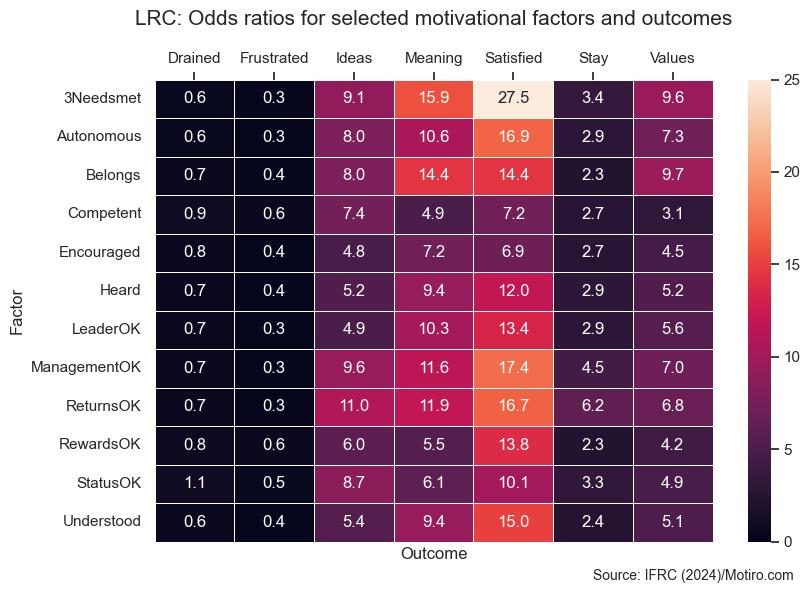

In [28]:
#  COUNTRY PROFILE: LEBANON
#  Odds ratios for staying, being staisfied, being frustrated  and being drained
#  and selected independent variables: Needs, Management, leadership
#  using logistic regression
#  use this to prepare odds ratio pivot table for VOL and STAFF and heatmap

from scipy.stats import fisher_exact
import itertools
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('LogReg_df.csv')

# Filter the dataframe for 'country' = 'Ukraine'
df = df[df['Country'] == 'Lebanon']

columnY = ['Stay', 'Drained', 'Frustrated', 'Satisfied', 'Meaning', 'Values', 'Ideas'] 
columnX = ['3Needsmet', 'Autonomous', 'Belongs', 'Competent',
           'LeaderOK', 'Understood', 'Encouraged', 'Heard',
           'ManagementOK', 'ReturnsOK', 'RewardsOK', 'StatusOK']

#create the dataframe that will store the outputs
results_df= pd.DataFrame(columns=['Outcome', 'Factor', 'Odds ratio'])

for Y in columnY:
    for X in columnX:
        clf = LogisticRegression(penalty=None)
        # Reshape the data to be 2D
        X_data = df[X].values.reshape(-1, 1)
        Y_data = df[Y]
        clf.fit(X_data, Y_data)
        odds_ratio = np.exp(clf.coef_)
        print(Y, X, odds_ratio)
        # Append results to the results_df DataFrame using pd.concat
        new_row = pd.DataFrame({'Outcome': [Y], 'Factor': [X], 'Odds ratio': [odds_ratio[0][0]]})
        results_df = pd.concat([results_df, new_row], ignore_index=True)

# Display the results DataFrame
#print(results_df)

# Save the results DataFrame to a CSV file
results_df.to_csv('odds_ratios_Lebanon.csv', index=False)

# Pivot the results_df DataFrame
pivot_table = results_df.pivot(index='Factor', columns='Outcome', values='Odds ratio')

# Display the pivot_table
#print(pivot_table)

# Save the Pivot table DataFrame to a CSV file
pivot_table.to_excel('odds_ratios_PivotTable_Lebanon.xlsx', index=False)      

# heatmap to represent odds ratios for LEBANESE RED CROSS only (all are volunteers)
sns.set_theme()

df = pd.read_csv('odds_ratios_Lebanon.csv')

# Pivot the results_df DataFrame
pivot_table = df.pivot(index='Factor', columns='Outcome', values='Odds ratio')

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(pivot_table, annot=True, fmt=".1f", vmin=0, vmax=25, linewidths=.5, ax=ax)
ax.xaxis.tick_top()
#ax.set_xlabel('Outcome', x=0.5)

plt.text(5.5, 13, "Source: IFRC (2024)/Motiro.com", fontdict={'size': 10})
plt.title('LRC: Odds ratios for selected motivational factors and outcomes', x=0.5, y=1.1, fontsize=15)

# Save the plot as an image file
plt.savefig('Lebanon_OR_heatmap.png')

Stay 3Needsmet [[24.07812039]]
Stay Autonomous [[15.29710313]]
Stay Belongs [[8.00600029]]
Stay Competent [[11.82471615]]
Stay LeaderOK [[10.71505316]]
Stay Understood [[8.96783265]]
Stay Encouraged [[5.53520212]]
Stay Heard [[8.96079976]]
Stay ManagementOK [[25.62281008]]
Stay ReturnsOK [[16.19806568]]
Stay RewardsOK [[13.52259483]]
Stay StatusOK [[26.23608262]]
Drained 3Needsmet [[0.13106208]]
Drained Autonomous [[0.17499374]]
Drained Belongs [[0.29528799]]
Drained Competent [[0.4803131]]
Drained LeaderOK [[0.25935425]]
Drained Understood [[0.2450451]]
Drained Encouraged [[0.39175555]]
Drained Heard [[0.37165152]]
Drained ManagementOK [[0.25141005]]
Drained ReturnsOK [[0.37162798]]
Drained RewardsOK [[0.34762504]]
Drained StatusOK [[0.17445592]]
Frustrated 3Needsmet [[0.05274393]]
Frustrated Autonomous [[0.08820116]]
Frustrated Belongs [[0.12998625]]
Frustrated Competent [[0.18727539]]
Frustrated LeaderOK [[0.13618286]]
Frustrated Understood [[0.1059076]]
Frustrated Encouraged [[0.26

C:\Users\gabriel.pictet\AppData\Local\Temp\ipykernel_20640\3381501301.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


Satisfied ManagementOK [[33.09632718]]
Satisfied ReturnsOK [[26.63287794]]
Satisfied RewardsOK [[24.46691613]]
Satisfied StatusOK [[27.79840389]]
Meaning 3Needsmet [[33.83584441]]
Meaning Autonomous [[20.31874472]]
Meaning Belongs [[40.05529262]]
Meaning Competent [[10.70962946]]
Meaning LeaderOK [[14.27635684]]
Meaning Understood [[19.14996222]]
Meaning Encouraged [[13.05098379]]
Meaning Heard [[8.94615238]]
Meaning ManagementOK [[25.37382655]]
Meaning ReturnsOK [[19.1184271]]
Meaning RewardsOK [[18.18694893]]
Meaning StatusOK [[16.29884718]]
Values 3Needsmet [[40.95409573]]
Values Autonomous [[19.7463687]]
Values Belongs [[19.54492423]]
Values Competent [[12.58398456]]
Values LeaderOK [[17.68926636]]
Values Understood [[24.82219627]]
Values Encouraged [[7.90590178]]
Values Heard [[12.90127]]
Values ManagementOK [[21.51153695]]
Values ReturnsOK [[17.1002959]]
Values RewardsOK [[7.29099122]]
Values StatusOK [[15.90317536]]
Ideas 3Needsmet [[16.98052753]]
Ideas Autonomous [[8.71099193]]

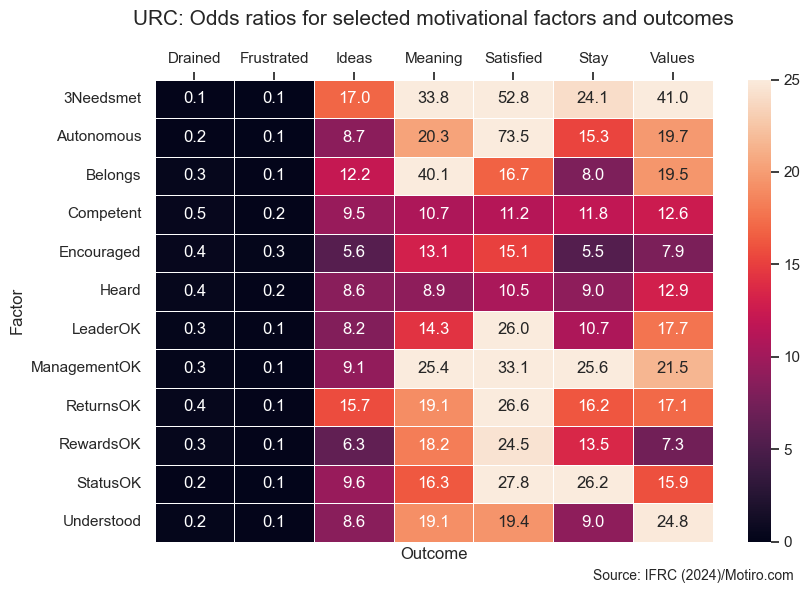

In [29]:
#  COUNTRY PROFILE: UKRAINE
#  Odds ratios for staying, being staisfied, being frustrated  and being drained
#  and selected independent variables: Needs, Management, leadership
#  using logistic regression
#  use this to prepare odds ratio pivot table for VOL and STAFF and heatmap

from scipy.stats import fisher_exact
import itertools
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('LogReg_df.csv')

# Filter the dataframe for 'country' = 'Ukraine'
df = df[df['Country'] == 'Ukraine']

columnY = ['Stay', 'Drained', 'Frustrated', 'Satisfied', 'Meaning', 'Values', 'Ideas'] 
columnX = ['3Needsmet', 'Autonomous', 'Belongs', 'Competent',
           'LeaderOK', 'Understood', 'Encouraged', 'Heard',
           'ManagementOK', 'ReturnsOK', 'RewardsOK', 'StatusOK']

#create the dataframe that will store the outputs
results_df= pd.DataFrame(columns=['Outcome', 'Factor', 'Odds ratio'])

for Y in columnY:
    for X in columnX:
        clf = LogisticRegression(penalty=None)
        # Reshape the data to be 2D
        X_data = df[X].values.reshape(-1, 1)
        Y_data = df[Y]
        clf.fit(X_data, Y_data)
        odds_ratio = np.exp(clf.coef_)
        print(Y, X, odds_ratio)
        # Append results to the results_df DataFrame using pd.concat
        new_row = pd.DataFrame({'Outcome': [Y], 'Factor': [X], 'Odds ratio': [odds_ratio[0][0]]})
        results_df = pd.concat([results_df, new_row], ignore_index=True)

# Display the results DataFrame
#print(results_df)

# Save the results DataFrame to a CSV file
results_df.to_csv('odds_ratios_Ukraine.csv', index=False)

# Pivot the results_df DataFrame
pivot_table = results_df.pivot(index='Factor', columns='Outcome', values='Odds ratio')

# Display the pivot_table
#print(pivot_table)

# Save the Pivot table DataFrame to a CSV file
pivot_table.to_excel('odds_ratios_PivotTable_Ukraine.xlsx', index=False)      

# heatmap to represent odds ratios for LEBANESE RED CROSS only (all are volunteers)
sns.set_theme()

df = pd.read_csv('odds_ratios_Ukraine.csv')

# Pivot the results_df DataFrame
pivot_table = df.pivot(index='Factor', columns='Outcome', values='Odds ratio')

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(pivot_table, annot=True, fmt=".1f", vmin=0, vmax=25, linewidths=.5, ax=ax)
ax.xaxis.tick_top()
#ax.set_xlabel('Outcome', x=0.5)

plt.text(5.5, 13, "Source: IFRC (2024)/Motiro.com", fontdict={'size': 10})
plt.title('URC: Odds ratios for selected motivational factors and outcomes', x=0.5, y=1.1, fontsize=15)

# Save the plot as an image file
plt.savefig('Ukraine_OR_heatmap.png')

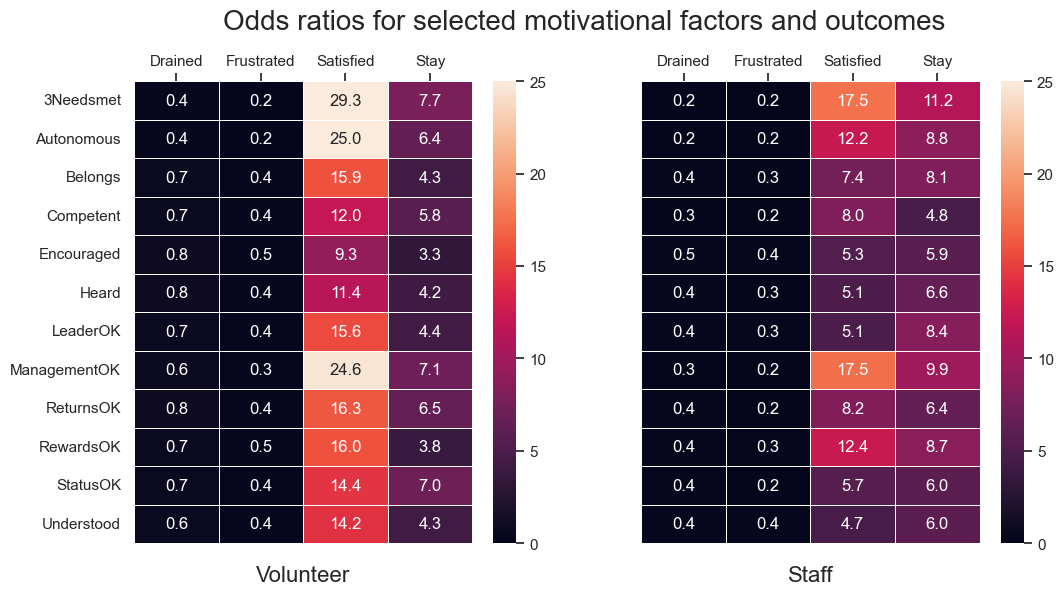

In [30]:
## Heatmap comparing Odds ratios for volunteers and staff

# Read volunteer and staff Odd ratio dataframes prepared above
df_volunteer = pd.read_csv('odds_ratios_VOL.csv')
df_staff = pd.read_csv('odds_ratios_STAFF.csv')

# Pivot the DataFrames
pivot_table_VOL = df_volunteer.pivot(index='Factor', columns='Outcome', values='Odds ratio')
pivot_table_STAFF = df_staff.pivot(index='Factor', columns='Outcome', values='Odds ratio')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))

# Plot the density heatmap for Volunteers
sns.heatmap(pivot_table_VOL, annot=True, fmt=".1f", vmin=0, vmax=25, linewidths=.5, ax=ax1)
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_title("Volunteer", fontsize=16, x=0.5, y=-0.1) # Change y value
ax1.xaxis.tick_top()

# Plot the density heatmap for Staff
sns.heatmap(pivot_table_STAFF, annot=True, fmt=".1f", vmin=0, vmax=25, linewidths=.5, ax=ax2)
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.set_title('Staff', fontsize=16, x=0.5, y=-0.1) # Change y value
ax2.xaxis.tick_top()

# Divider code (commented out in your provided code, kept as is)
#divider1 = make_axes_locatable(ax1)
#cax1 = divider1.append_axes("bottom", size="5%", pad=0.5)
#cbar1 = plt.colorbar(hex1, cax=cax1, orientation='horizontal')
#cbar1.set_label('Density')

#divider2 = make_axes_locatable(ax2)
#cax2 = divider2.append_axes("bottom", size="5%", pad=0.5)
#cbar2 = plt.colorbar(hex2, cax=cax2, orientation='horizontal')
#cbar2.set_label('Density')

# Adjust the spacing between subplots
#plt.tight_layout()
plt.suptitle('Odds ratios for selected motivational factors and outcomes', x=0.5, y=1, fontsize=20)

# Save the plot as an image file
plt.savefig('VOL-STAFF_OR_heatmap.png')

# Show the plot
plt.show()
